In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp


In [2]:
sns.set(rc={'figure.figsize':(24, 13.5)}, font_scale = 2.7)

In [3]:
recovery = pd.read_csv('recovery-data/recovery-data.csv', index_col = 'Time')
telemetry = pd.read_csv('maiden_launch_combined_telemetry.csv', index_col='Time [s]')
combined = recovery.drop_duplicates().sort_index().reset_index()

t_ig = 2280.35
t0 = t_ig-2 # time of start of plot [s]
duration = 35  # flight duration [s]
g = -9.81 # correct for gravity

combined['Time [s]'] = (combined['Time'])/1000 - t_ig
combined['Acceleration 1 [g]'] = (combined['Ay_IMU1'] / g)
combined['Acceleration 2 [g]'] = (combined['Ay_IMU2'] / g)
combined['Temperature [°C]'] = combined['T_SHT']
combined['Humidity [%]'] = combined['H_SHT']
#combined['Battery [V]'] = combined['battery_battery']/1000
combined['Pressure 1 [kPa]'] = combined['P_BARO1']/1000
combined['Pressure 2 [kPa]'] = combined['P_BARO2']/1000

gyro_labels = ['Gx_IMU1','Gy_IMU1','Gz_IMU1','Gx_IMU2','Gy_IMU2','Gz_IMU2']
acc_labels = ['Ax_IMU1','Ay_IMU1','Az_IMU1','Ax_IMU2','Ay_IMU2','Az_IMU2']

for label in gyro_labels:
    combined[label] /= 2
#convert to gs
fmt_acc = lambda x: x / 1024
#convert to degrees per second
fmt_gyro = lambda x: x / 16.4
dim3 = lambda x : [x + '_' + s for s in ['x', 'y', 'z']]

telemetry[dim3('Acceleration')] = telemetry[dim3('sb_data_acc')].apply(pd.to_numeric).apply(fmt_acc)
telemetry[dim3('Gyro')] = telemetry[dim3('sb_data_gyro')].apply(pd.to_numeric).apply(fmt_gyro)

telemetry.index += -1.55
#
combined = combined[combined['Time [s]']>-2].reset_index()
telemetry = telemetry[telemetry.index>-2].reset_index()

# Some options
show_telemetry = True     # whether to display telemetry data points
show_flight_events = True # whether to display ignition, burnout, apogee
show_actuation = True     # whether to display airbrake actuation areas

t_ignition = 0 # time of ignition [s]
t_burnout = 3.85  # time of burnout [s]
t_apogee = combined['Time [s]'][pd.Series.argmin(combined['Pressure 1 [kPa]'])]
0# time of apogee (min pressure) [s]

def plot_events(plt):
    if show_flight_events:
        plt.axvline(x=t_ignition, color='k')
        plt.axvline(x=t_burnout, color='k')
        plt.axvline(x=t_apogee, color='k')
    if show_actuation:
        plt.axvspan(5.25, 5.95, color='b', alpha=0.2)
        plt.axvspan(7.15, 8.25, color='b', alpha=0.2)
        plt.axvspan(9.55, 14.45, color='b', alpha=0.2)
        


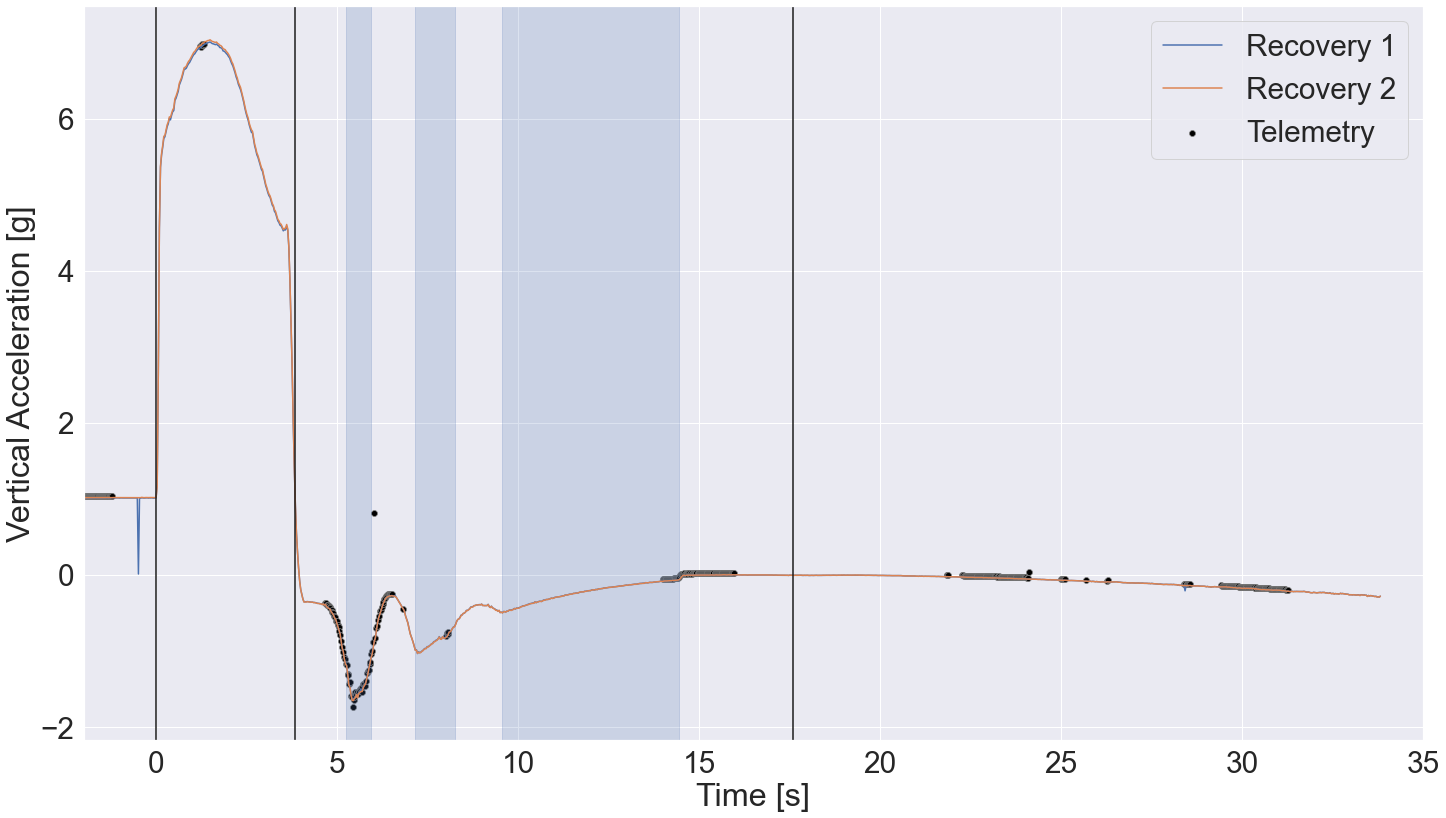

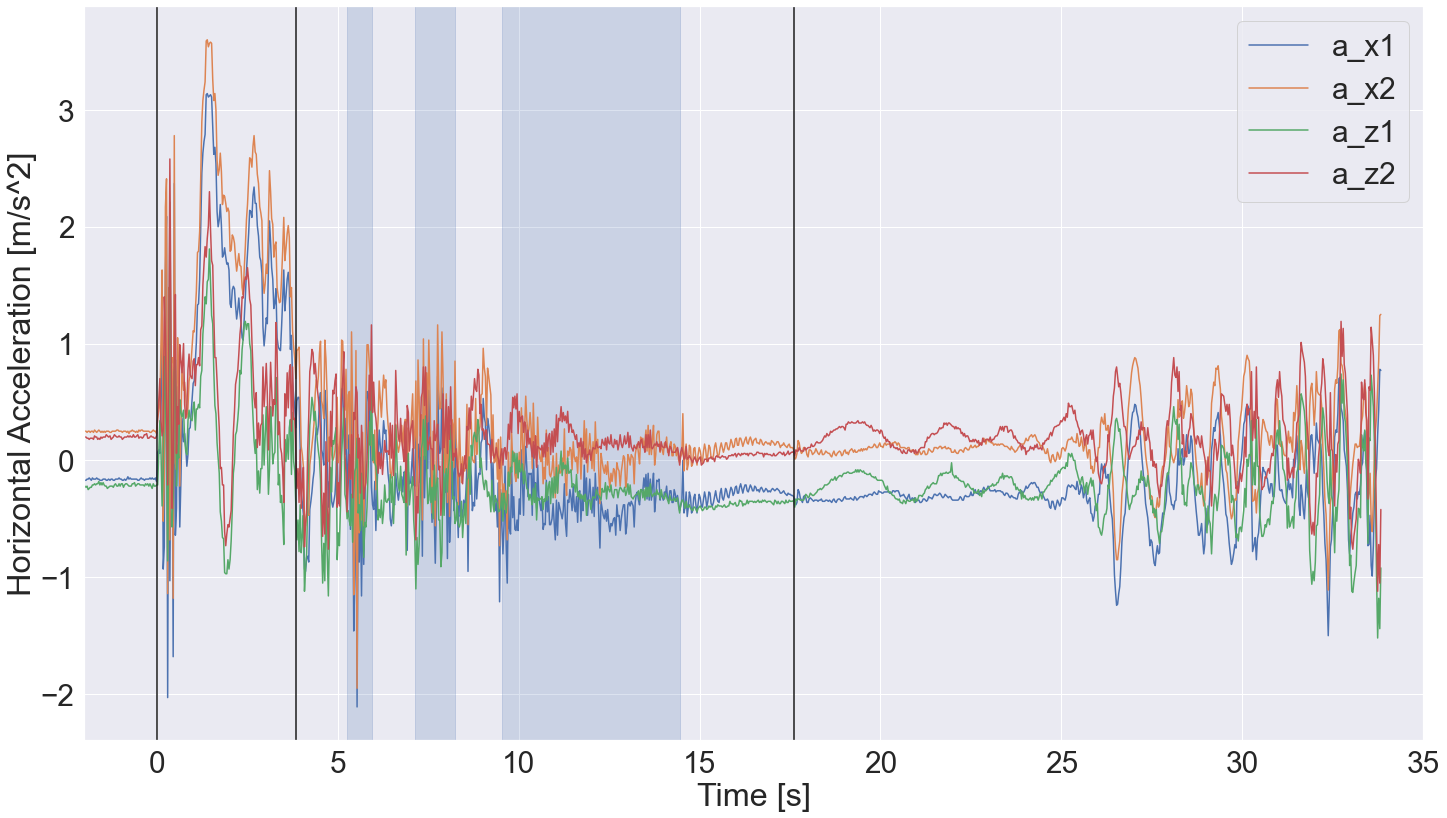

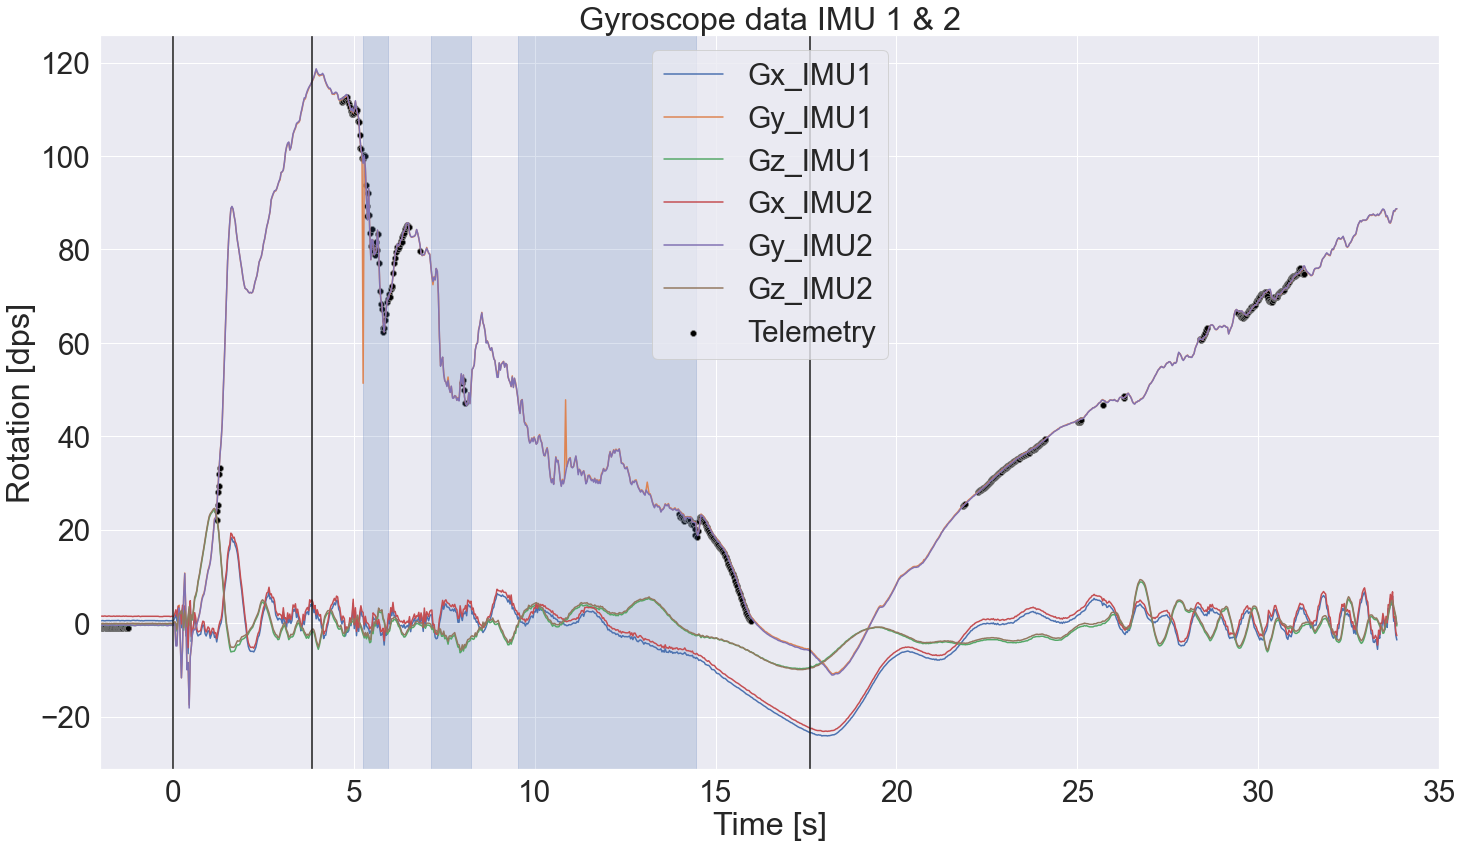

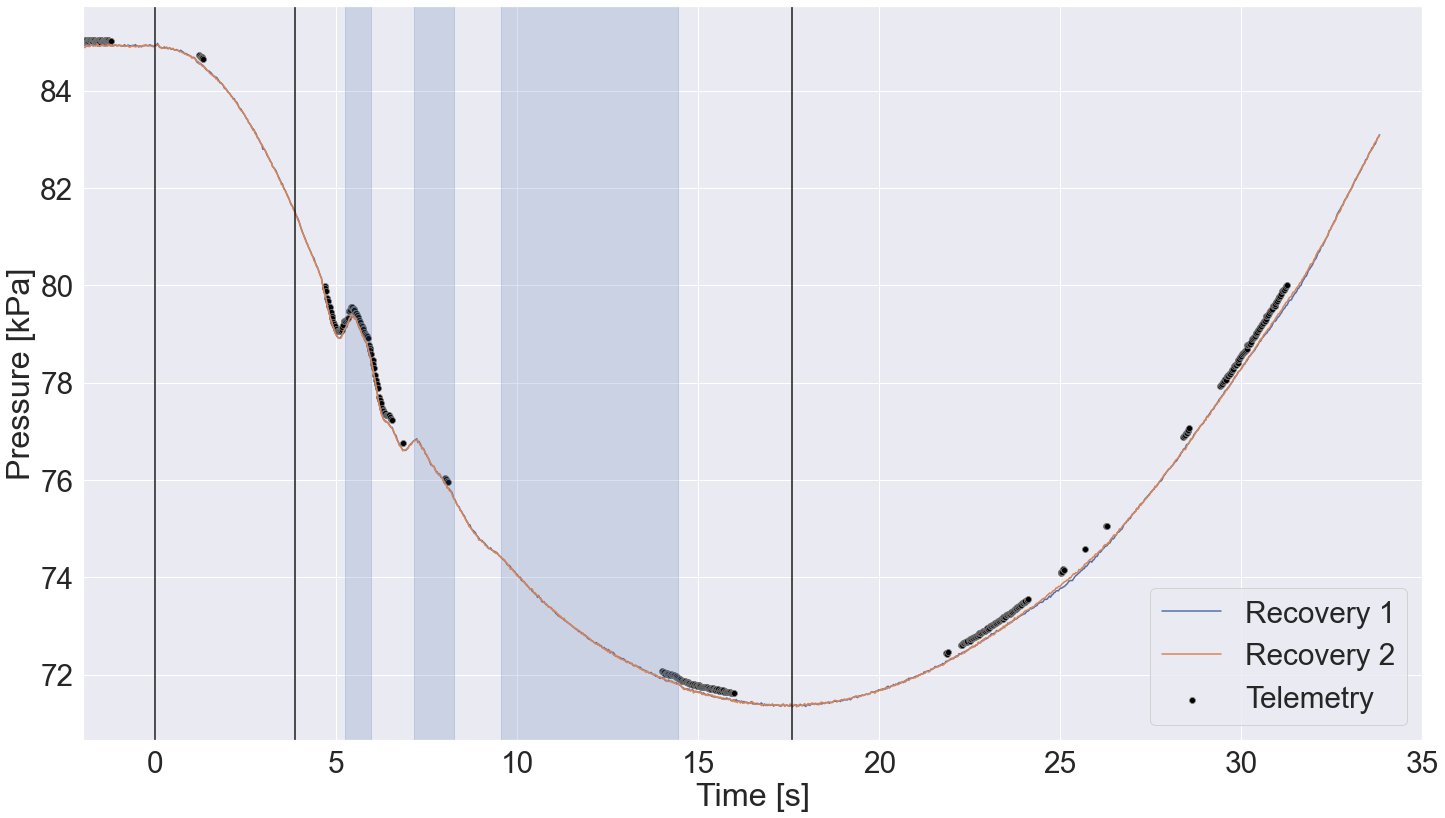

In [4]:
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# ACC ROLL AXIS PLOT
ax = sns.lineplot(data = combined, x = 'Time [s]', y = 'Acceleration 1 [g]', label="Recovery 1")
ax = sns.lineplot(data = combined, x = 'Time [s]', y = 'Acceleration 2 [g]', label="Recovery 2")

if show_telemetry:
    ax = sns.scatterplot(data = telemetry, x = 'Time [s]', y = 'Acceleration_z', color = 'black', edgecolor='gray', label='Telemetry')

plot_events(plt)

ax.set_ylabel('Vertical Acceleration [g]')
ax.set_xlabel('Time [s]')
ax.set_xlim(-2, duration)
plt.show()

# ACC HORIZONTAL PLOT
ax = sns.lineplot(data = combined, x = 'Time [s]', y = 'Ax_IMU1', label='a_x1')
ax = sns.lineplot(data = combined, x = 'Time [s]', y = 'Ax_IMU2', label='a_x2')
ax = sns.lineplot(data = combined, x = 'Time [s]', y = 'Az_IMU1', label='a_z1')
ax = sns.lineplot(data = combined, x = 'Time [s]', y = 'Az_IMU2', label='a_z2')
plot_events(plt)

ax.set_ylabel('Horizontal Acceleration [m/s^2]')
ax.set_xlabel('Time [s]')
ax.set_xlim(-2, duration)
plt.legend(loc='upper right')
plt.show()


# GYRO PLOT
for label in gyro_labels:
    ax = sns.lineplot(data = combined, x = 'Time [s]', y = label, label=label)

if show_telemetry:
    ax = sns.scatterplot(data = telemetry.reset_index(), x = 'Time [s]', y = 'Gyro_z', color = 'black', edgecolor='gray', label='Telemetry')

plot_events(plt)
ax.set_title(f'Gyroscope data IMU 1 & 2')
ax.set_ylabel('Rotation [dps]')
ax.set_xlabel('Time [s]')
ax.set_xlim(-2, duration)
plt.legend(loc='upper center')
plt.show()

#plt = sns.scatterplot(data = combined.reset_index(), x = 'Time [s]', y = 'Pressure [kPa]', color = 'black', edgecolor='gray')
ax = sns.lineplot(data = combined.reset_index(), x = 'Time [s]', y = 'Pressure 1 [kPa]', label="Recovery 1")
ax = sns.lineplot(data = combined.reset_index(), x = 'Time [s]', y = 'Pressure 2 [kPa]', label="Recovery 2")
plot_events(plt)

if show_telemetry:
    ax = sns.scatterplot(data = telemetry.reset_index(), x = 'Time [s]', y = 'Pressure [kPa]', color = 'black', edgecolor='gray', label='Telemetry')

ax.set_ylabel('Pressure [kPa]')
ax.set_xlabel('Time [s]')
ax.set_xlim(-2, duration)
plt.show()



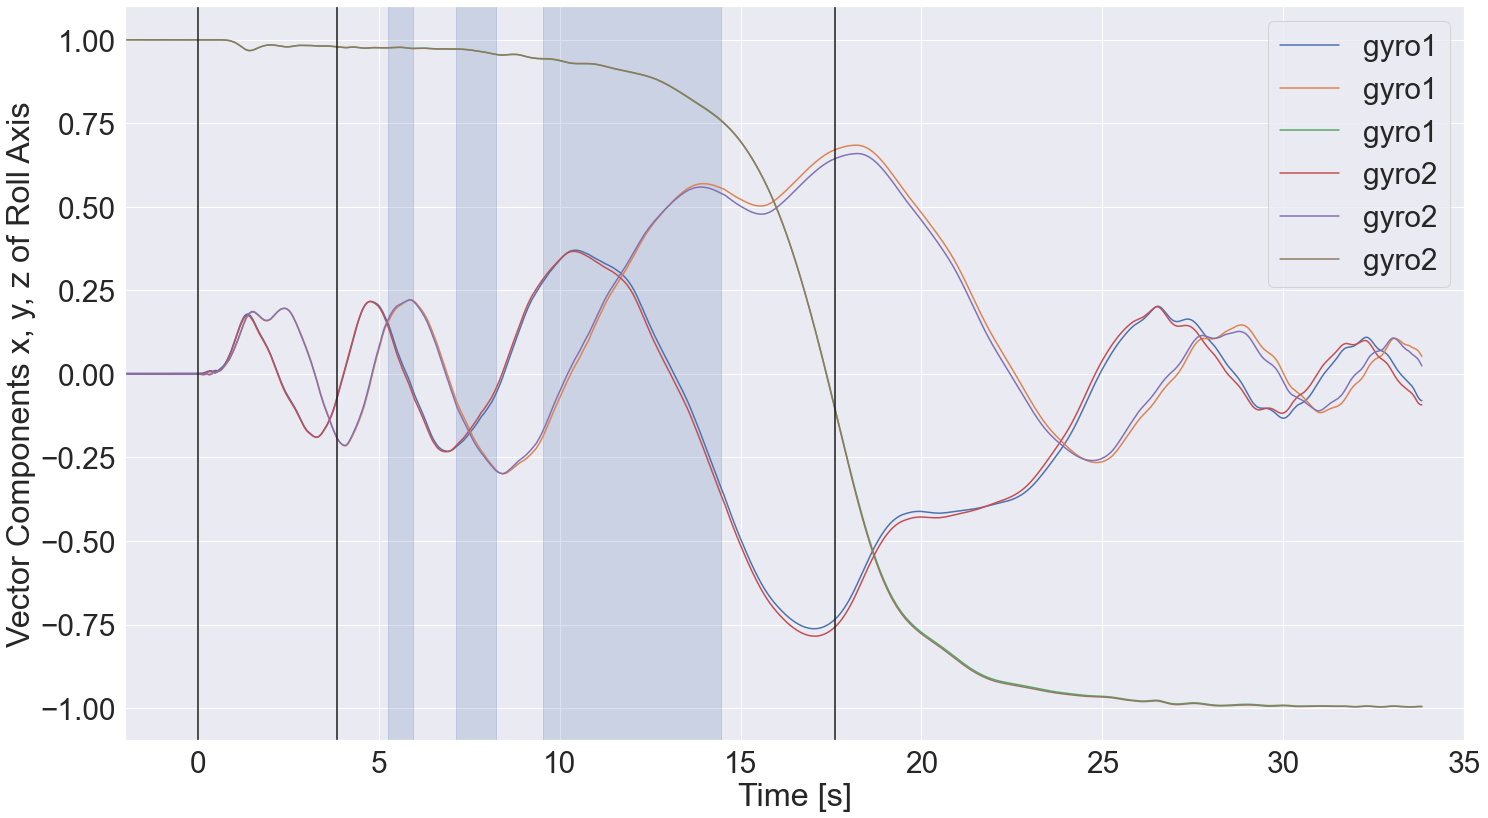

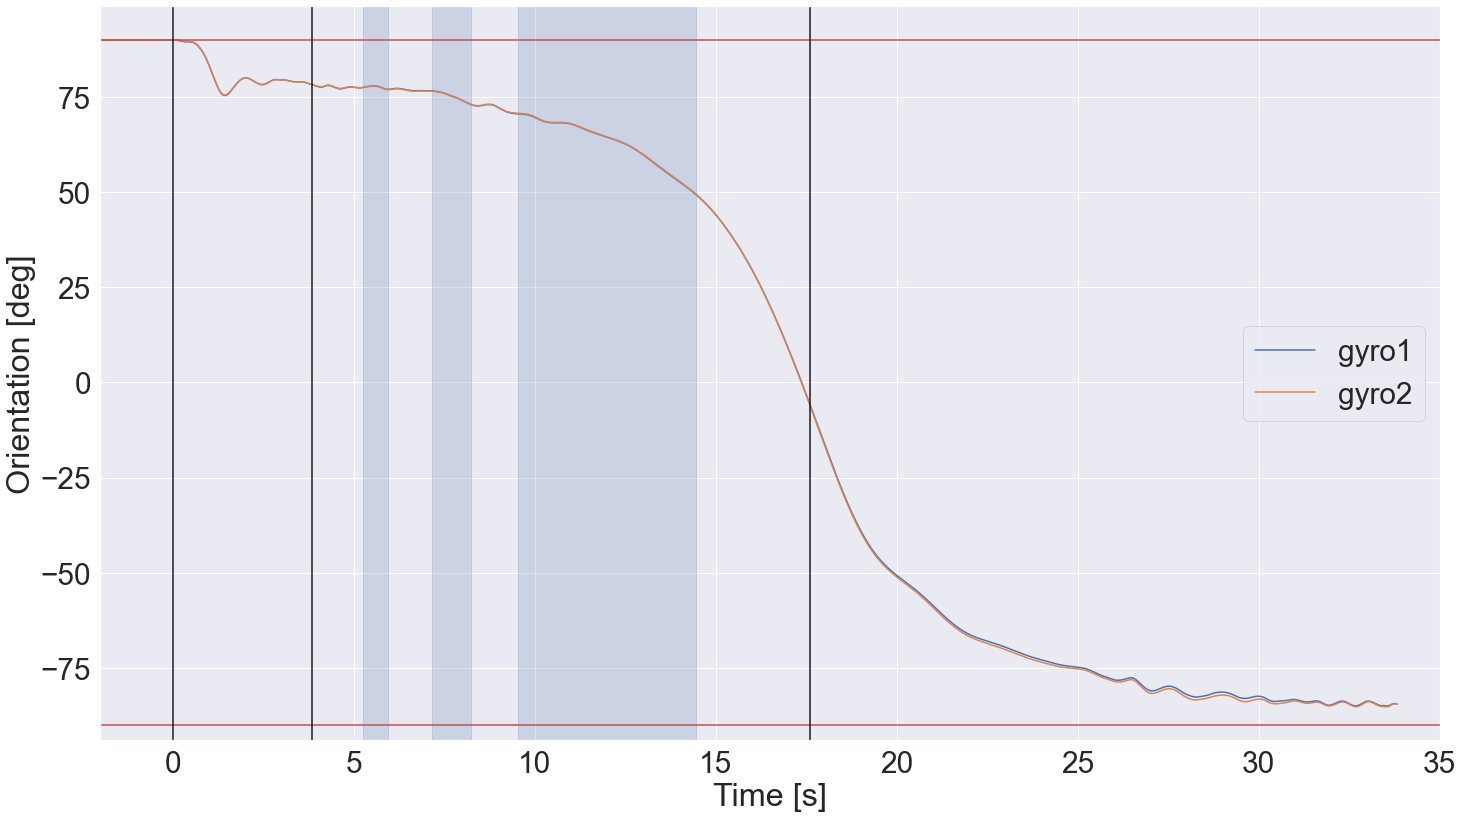

In [5]:
def compensate_gyro_offset(data, gyro_labels):
    for label in gyro_labels:
        data[label] = data[label] - data[label][combined["Time [s]"]<-0.2].mean()
    return data

def compensate_acc_offset(data, acc_labels):
    for label in acc_labels:
        if label[1]=="y":
            data[label] = data[label] - data[label][combined["Time [s]"]<-0.7].mean() - 9.81
        else:
            data[label] = data[label] - data[label][combined["Time [s]"]<-0.7].mean()
    return data

def get_rotations_from_gyro(t, gyro_x, gyro_y, gyro_z):
    dt_array = np.diff(np.array(t),prepend=0)
    W_gyro = np.array([gyro_x, gyro_y, gyro_z]) / 180*np.pi * dt_array
    dR_array = R.from_rotvec(W_gyro.T)
    return dR_array

def get_orientations_from_rots(R_array):
    RA = np.array([0,0,1])
    rot0 = R.from_euler('yx', [0,0],degrees=True)
    RA = rot0.apply(RA)

    
    RA_array = []
    for i in R_array:
        RA = i.apply(RA)
        RA_array.append(RA)
    RA_array = np.array(RA_array)
    return RA_array


def derot_array(array, rot_angle):
    R_derot = R.from_euler("z", rot_angle, degrees=True)
    array_derot = R_derot.apply(array)
    return array_derot

# altitude and hor distance of lr and td (in m)
alt_LR = 1563
pos_LR = 0
alt_TD = 1730
pos_TD = 591

# relative orientaion of rocket (IMU) wrt to horizontal flight path
rot_angel = 28 # degrees

combined = compensate_gyro_offset(combined, gyro_labels)
combined = compensate_acc_offset(combined, acc_labels)

dR_array1 = get_rotations_from_gyro(combined["Time [s]"],combined["Gx_IMU1"],combined["Gz_IMU1"],combined["Gy_IMU1"])
dR_array2 = get_rotations_from_gyro(combined["Time [s]"],combined["Gx_IMU2"],combined["Gz_IMU2"],combined["Gy_IMU2"])

RA_array1  = get_orientations_from_rots(dR_array1)
RA_array2  = get_orientations_from_rots(dR_array2)

RA_array1  = derot_array(RA_array1, rot_angle=28)
RA_array2  = derot_array(RA_array2, rot_angle=28)

plt.plot(combined["Time [s]"], RA_array1, label="gyro1")
plt.plot(combined["Time [s]"], RA_array2, label="gyro2")
plt.xlim(-2, duration)
plt.xlabel("Time [s]")
plt.ylabel("Vector Components x, y, z of Roll Axis")
plt.legend()
plot_events(plt)
plt.show()

def plot_RA_angle(t_array, RA_array, label):
    plt.plot(t_array,90-180/np.pi*np.arccos(RA_array[:,2]), label=label)
    
plot_RA_angle(combined["Time [s]"], RA_array1, "gyro1")
plot_RA_angle(combined["Time [s]"], RA_array2, "gyro2")
plt.xlabel("Time [s]")
plt.ylabel("Orientation [deg]")
plt.axhline(90, color="r")
plt.axhline(-90, color="r")
plt.legend()
plt.xlim(-2, duration)
plot_events(plt)
plt.show()


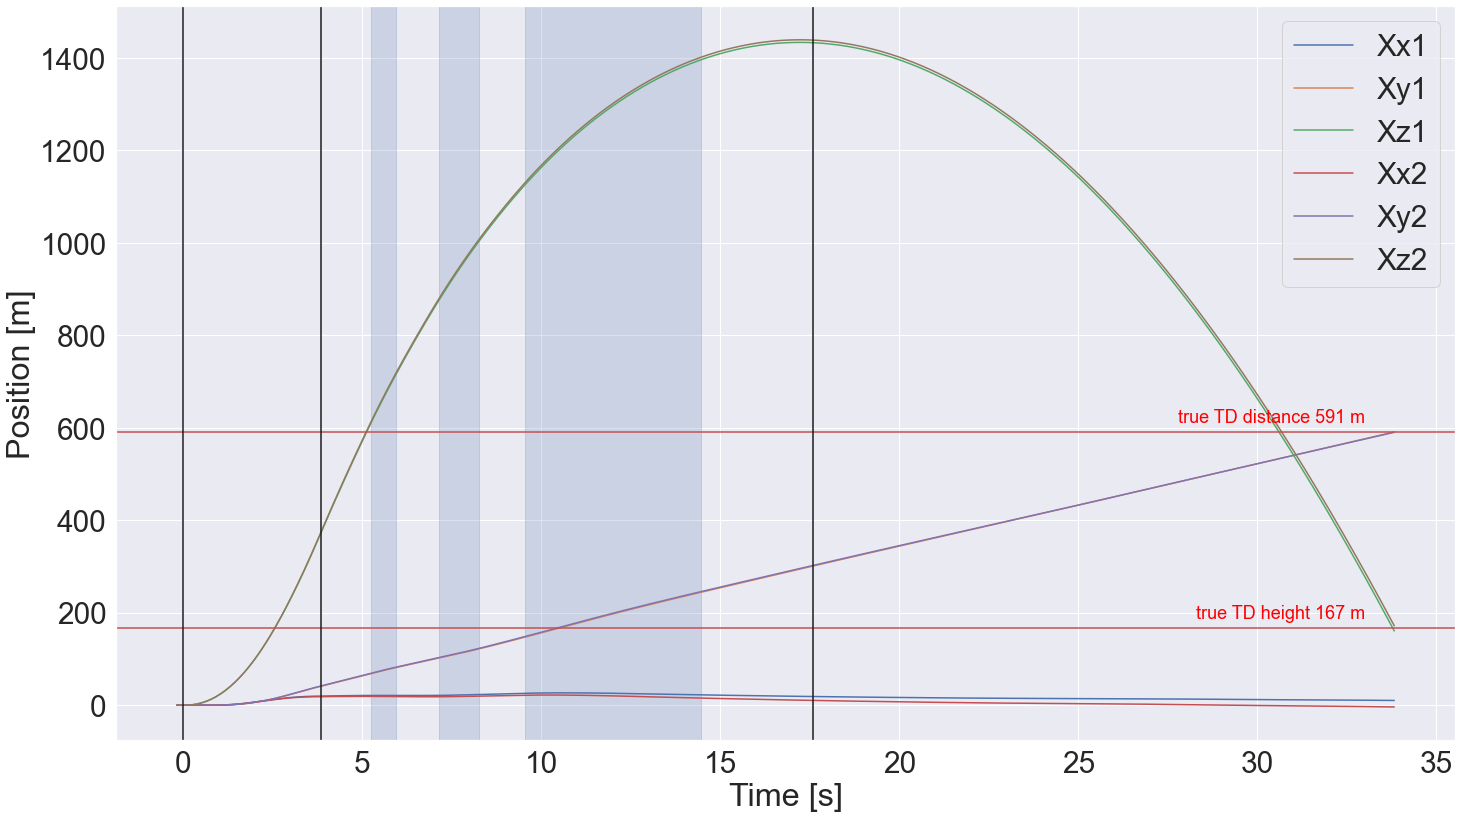

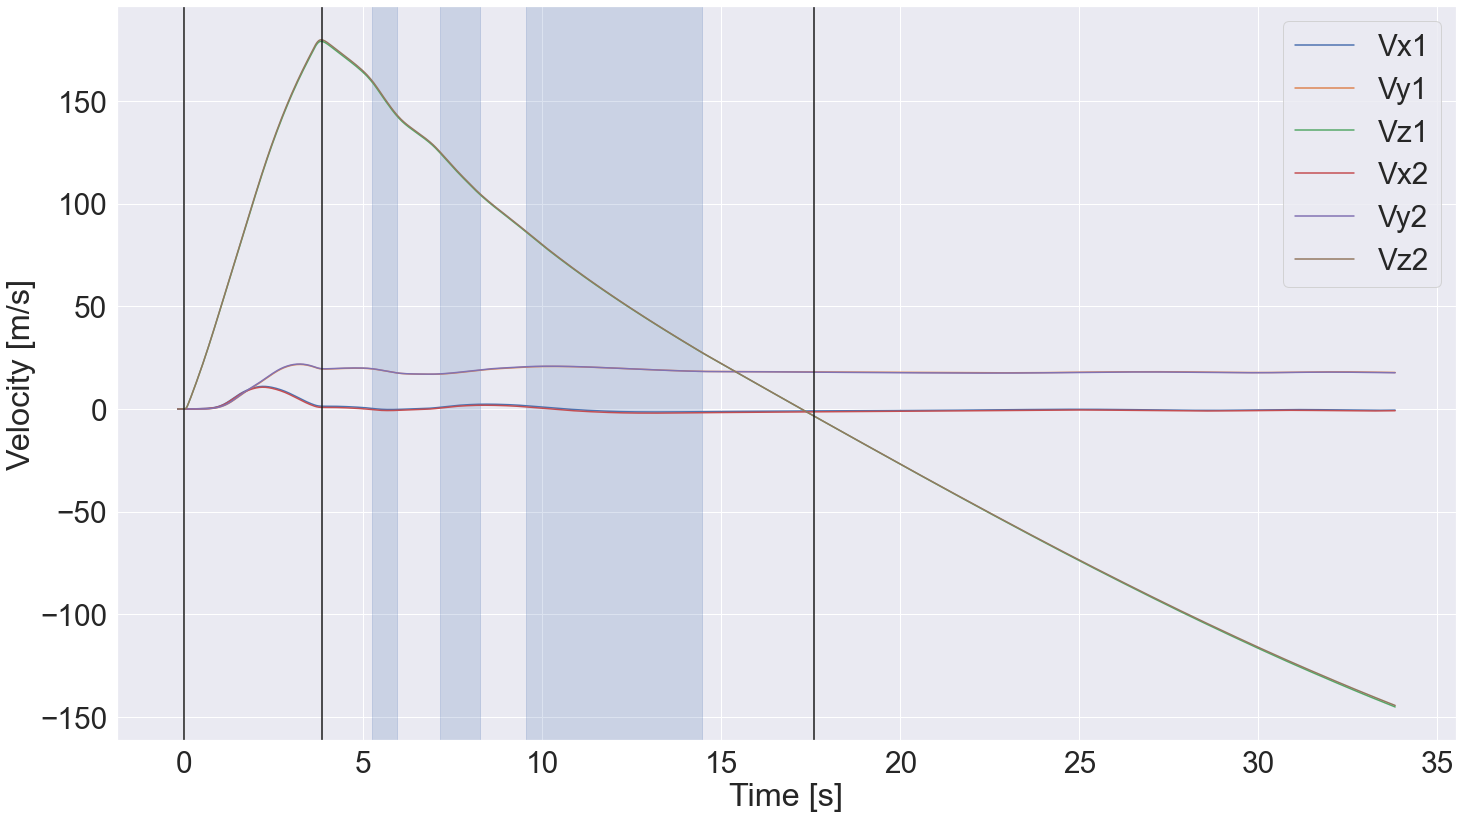

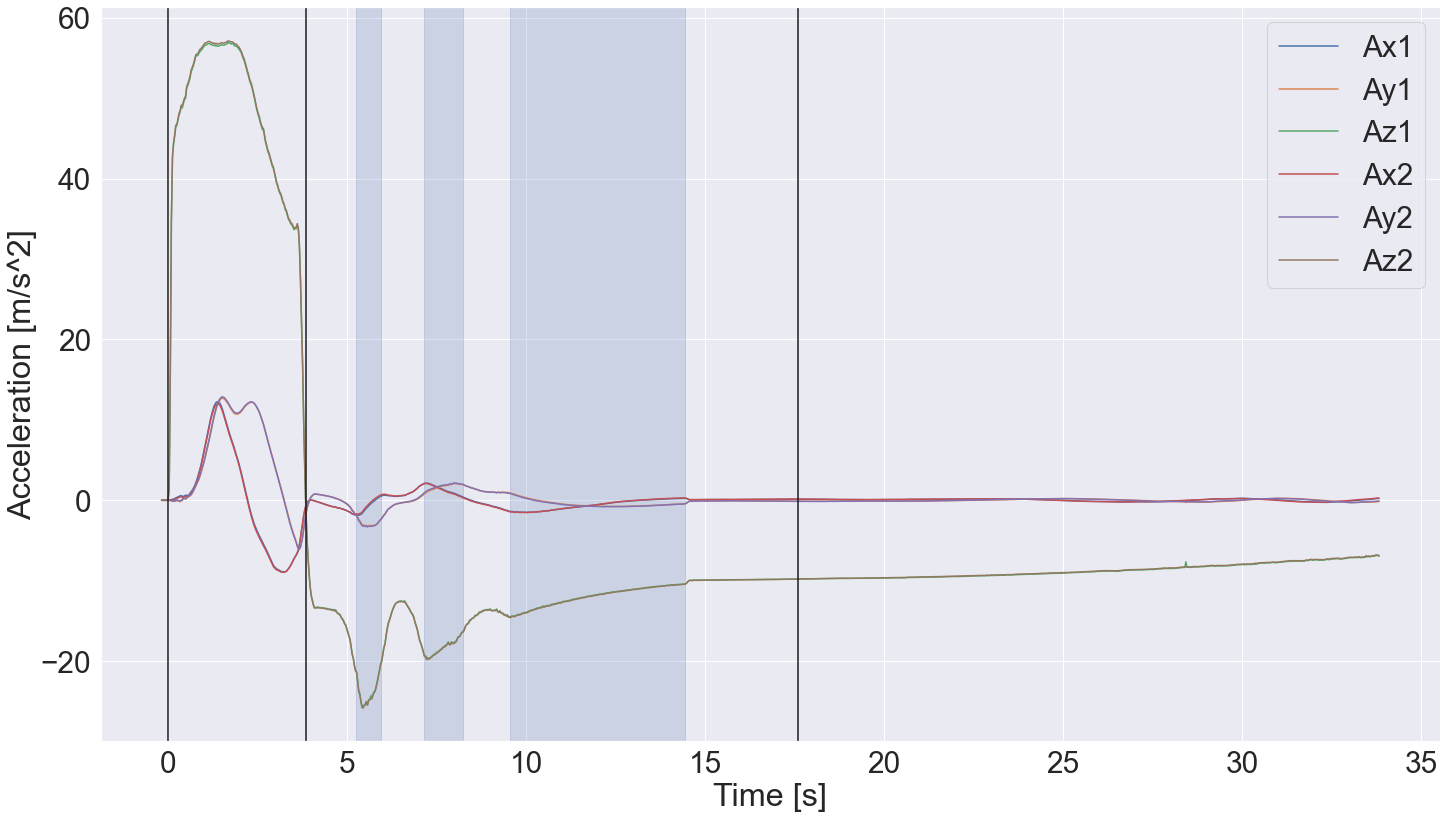

In [6]:
def get_velocity_and_position(t_array, RA_array, a_RA_array):
    cond_launch = t_array>-0.2
    t_array = np.array(t_array[cond_launch])
    RA_array = np.array(RA_array[cond_launch])
    a_RA_array = np.array(a_RA_array[cond_launch])

    n = len(t_array)
    X = np.array([0,0,0]).astype(float)
    V = np.array([0,0,0]).astype(float)
    A = np.array([0,0,0]).astype(float)
    X_array = np.zeros((n,3))
    V_array = np.zeros((n,3))
    A_array = np.zeros((n,3))
    
    dt_array = np.diff(np.array(t_array),prepend=0)
    
    g = 9.81
    A_g = np.array([0,0,-g])
    
    for i in range(len(t_array)):
        A = a_RA_array[i] * RA_array[i] + A_g
        V += A * dt_array[i]
        X += V * dt_array[i]
        
        A_array[i] = A
        V_array[i] = V
        X_array[i] = X
        
    return t_array, X_array, V_array, A_array

a_RA_array1 = -combined["Ay_IMU1"]
a_RA_array2 = -combined["Ay_IMU2"]
t_array1, X_array1, V_array1, A_array1 = get_velocity_and_position(combined["Time [s]"], RA_array1, a_RA_array1)
t_array2, X_array2, V_array2, A_array2 = get_velocity_and_position(combined["Time [s]"], RA_array2, a_RA_array2)

def plot_3d_array(t_array, array, vector_type):
    comps = ["x","y","z"]
    for i in range(array.shape[1]):
        plt.plot(t_array, array[:,i], label=vector_type[0]+comps[i]+vector_type[-1])
        plt.xlabel("Time [s]")
        

plot_3d_array(t_array1, X_array1, vector_type="X1")
plot_3d_array(t_array2, X_array2, vector_type="X2")
plt.ylabel("Position [m]")
plt.axhline(alt_TD-alt_LR, color="r")
plt.axhline(pos_TD-pos_LR, color="r")
plt.text(33, pos_TD-pos_LR+20, f"true TD distance {pos_TD-pos_LR:.0f} m", fontsize=18, ha="right", color="red")
plt.text(33, alt_TD-alt_LR+20, f"true TD height {alt_TD-alt_LR:.0f} m", fontsize=18, ha="right", color="red")

plt.legend()
plot_events(plt)
plt.show()

plot_3d_array(t_array1, V_array1, vector_type="V1")
plot_3d_array(t_array2, V_array2, vector_type="V2")
plt.ylabel("Velocity [m/s]")
plt.legend()
plot_events(plt)
plt.show()

plot_3d_array(t_array1, A_array1, vector_type="A1")
plot_3d_array(t_array2, A_array2, vector_type="A2")
plt.legend()
plt.ylabel("Acceleration [m/s^2]")
plot_events(plt)
plt.show()

Text(0, 0.5, 'Control input []')

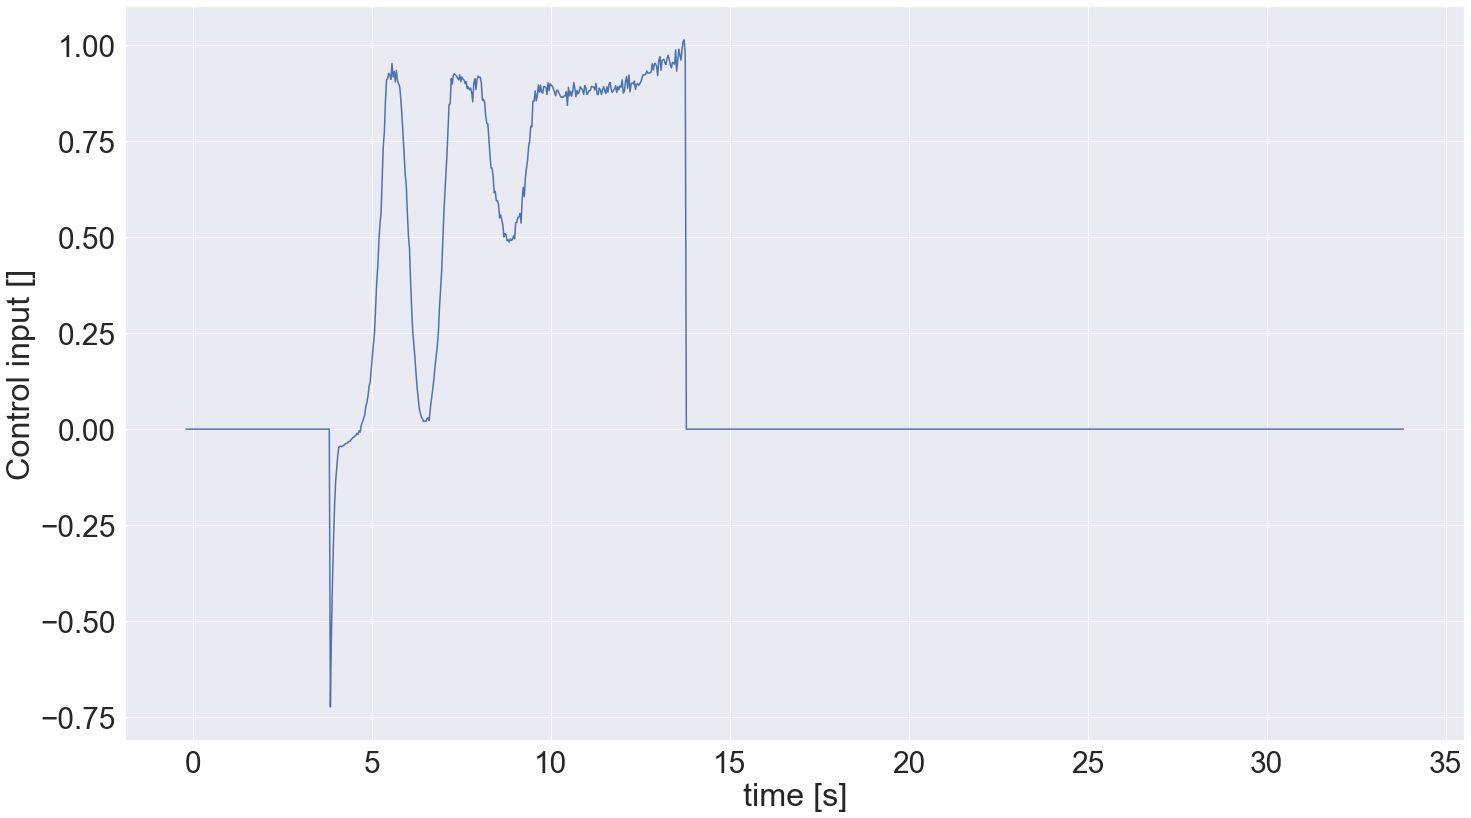

In [15]:
# Control plots

def compute_density(actual_temp):
    Temp_grad = 0.0065
    R_star = 8.3144598
    M = 0.0289644
    R = R_star / M
    n = (-g / (Temp_grad * R)) - 1
    Temp_0 = 273.15
    Temp_g = 10
    Temp_g = Temp_0 + Temp_g
    rho_sea = 1.225
    P_sea = 1.01325e5
    Temp_sea = 288.15
    Pressure_g = 85000
    actual_temp = actual_temp + Temp_0

    rho_g = rho_sea * ((Pressure_g / P_sea) * (Temp_sea / Temp_g))
    rho = rho_g * (actual_temp / Temp_g) ** n
    return rho

def compute_speed_of_sound(actual_temp):
    gamma = 1.4
    R_star = 8.3144598
    M = 0.0289644
    R = R_star / M
    Temp_0 = 273.15
    actual_temp = actual_temp + Temp_0
    return np.sqrt(gamma * R * actual_temp)

def compute_control_input(acc, vel, temp, method='theoretical'):
    if method == 'theoretical':
        n = len(acc)
        control_input = np.zeros(n)
        ca_rocket = 0.26
        mult_AB = 5.1
        m_rocket_engineless = 31.5      # kg
        A_ref_rocket = m.pi * (0.179/2)**2

        control_activation_mach_number = 0.55
        control_deactivation_mach_number = 0.1

        for i in range(n):
            speed_of_sound = compute_speed_of_sound(temp[i])
            mach_number = vel[i] / speed_of_sound
            if (control_deactivation_mach_number < mach_number < control_activation_mach_number) and acc[i] < 0:
                rho = compute_density(actual_temp=temp[i])
                control_input[i] = (-(acc[i] - g) * 2 * m_rocket_engineless /(rho * A_ref_rocket * ca_rocket * vel[i]**2) - 1)/(mult_AB - 1)
    else:
        raise Exception('Control input method not defined')

    return control_input

import math as m
# First assumption: cd values known

control_input = compute_control_input(acc=A_array1[:, 2], vel=V_array1[: ,2], temp=np.array(combined['Temperature [°C]']))

plt.plot(t_array1, control_input)
plt.xlabel('time [s]')
plt.ylabel('Control input []')